# <h1 style="font-family: Trebuchet MS; padding: 20px; font-size: 25px; color: #2D2926; text-align: center; line-height: 1.5;background-color: #d13afbff"><b>Anomaly Detection Project</b><br></h1>

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# <center><div style="font-family: Trebuchet MS; background-color: #3c75fbff; color: #2D2926; padding: 12px; line-height: 0.75;">Dataset Exploration</div></center>

=== data head ===
   Time    V1    V2   V3    V4    V5    V6    V7    V8    V9  ...   V21   V22  \
0  0.00 -1.36 -0.07 2.54  1.38 -0.34  0.46  0.24  0.10  0.36  ... -0.02  0.28   
1  0.00  1.19  0.27 0.17  0.45  0.06 -0.08 -0.08  0.09 -0.26  ... -0.23 -0.64   
2  1.00 -1.36 -1.34 1.77  0.38 -0.50  1.80  0.79  0.25 -1.51  ...  0.25  0.77   
3  1.00 -0.97 -0.19 1.79 -0.86 -0.01  1.25  0.24  0.38 -1.39  ... -0.11  0.01   
4  2.00 -1.16  0.88 1.55  0.40 -0.41  0.10  0.59 -0.27  0.82  ... -0.01  0.80   

    V23   V24   V25   V26   V27   V28  Amount  Class  
0 -0.11  0.07  0.13 -0.19  0.13 -0.02  149.62      0  
1  0.10 -0.34  0.17  0.13 -0.01  0.01    2.69      0  
2  0.91 -0.69 -0.33 -0.14 -0.06 -0.06  378.66      0  
3 -0.19 -1.18  0.65 -0.22  0.06  0.06  123.50      0  
4 -0.14  0.14 -0.21  0.50  0.22  0.22   69.99      0  

[5 rows x 31 columns]
=== data info===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  N

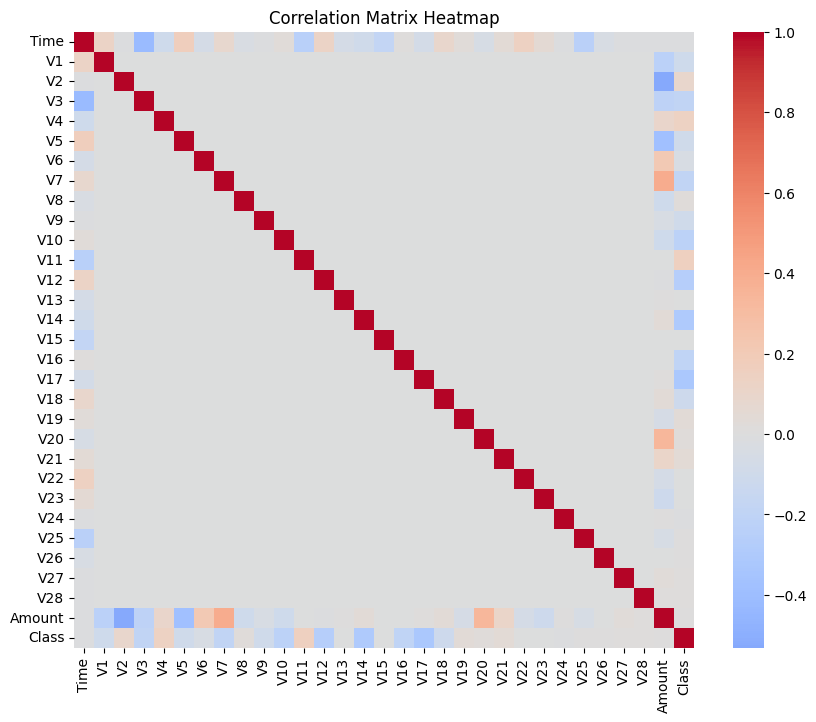

=== heatmap ===


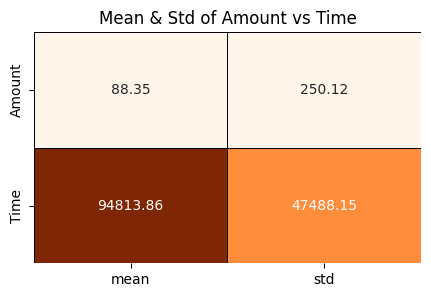

=== Distribution of Amount ===


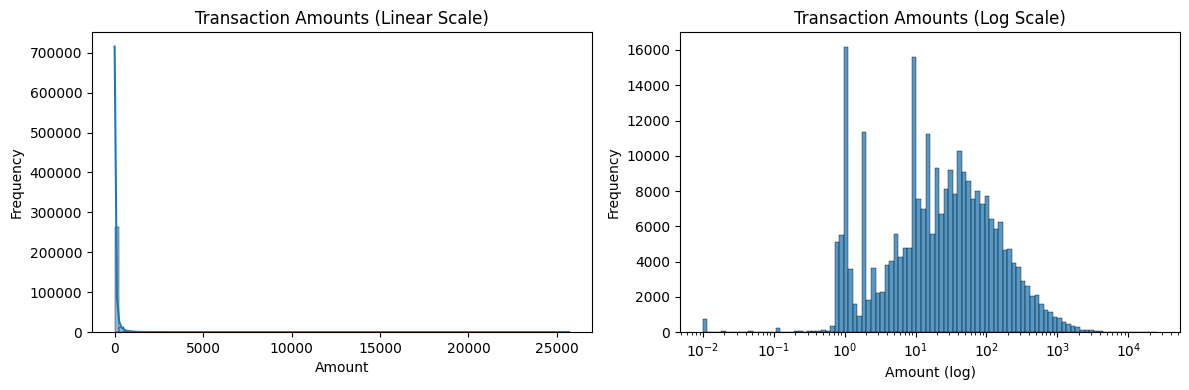

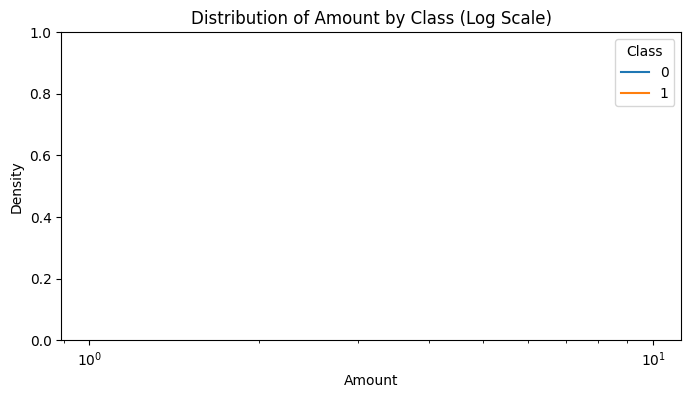

=== Distribution of Time ===


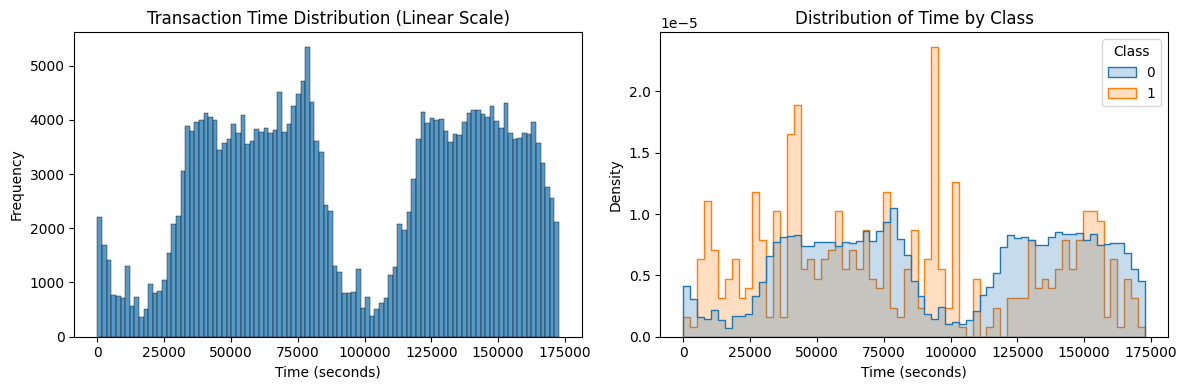

=== Class imbalance ===


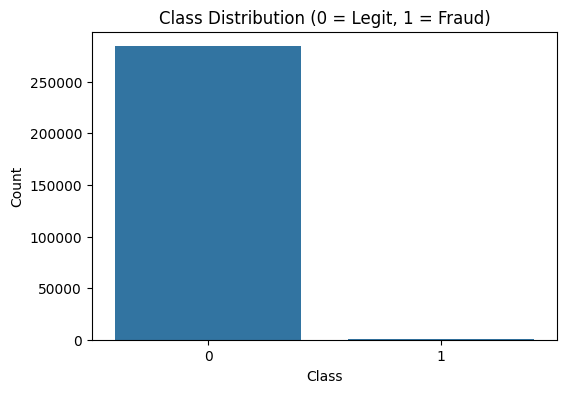

=== Boxplot for Outliers ===


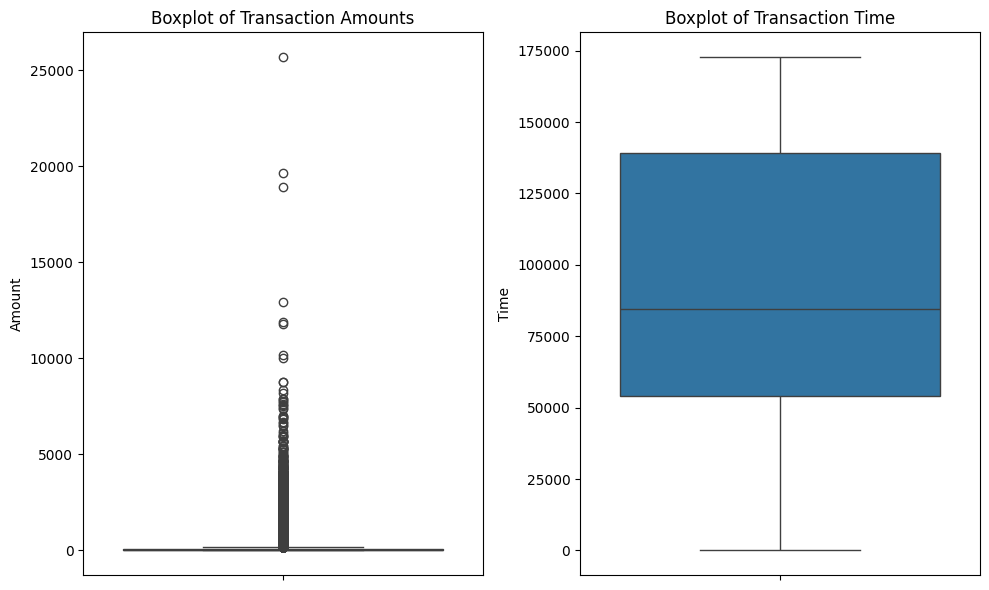

In [2]:
data = pd.read_csv('data/creditcard.csv')

print("=== data head ===")
print(data.head())

print("=== data info===")
data.info()

print("=== Null values check ===")
print(data.isnull().sum())

print("=== data describe===")
print(data[['Amount', 'Time']].describe())

print("=== Class Distribution (normalized) ===")
print(data['Class'].value_counts(normalize=True))

print("=== Mean Values: Amount vs Time by Class ===")
print(data.groupby('Class')[['Amount', 'Time']].mean())

print("=== Correlation Matrix ===")
plt.figure(figsize=(10,8))
corr = data.corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Matrix Heatmap")
plt.show()


print("=== heatmap ===")
plt.figure(figsize=(5,3))
sns.heatmap(
    data[['Amount','Time']].describe().T[['mean','std']], 
    cmap='Oranges', annot=True, fmt='.2f',
    linecolor='black', linewidths=0.4, cbar=False
)
plt.title('Mean & Std of Amount vs Time')
plt.show()


print("=== Distribution of Amount ===")
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data['Amount'], bins=100, kde=True)
plt.title("Transaction Amounts (Linear Scale)")
plt.xlabel("Amount")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
sns.histplot(data['Amount'], bins=100, log_scale=True)
plt.title("Transaction Amounts (Log Scale)")
plt.xlabel("Amount (log)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# KDE by Class (Amount)
plt.figure(figsize=(8,4))
sns.kdeplot(data=data, x='Amount', hue='Class', log_scale=True, common_norm=False)
plt.title("Distribution of Amount by Class (Log Scale)")
plt.show()

print("=== Distribution of Time ===")
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data['Time'], bins=100, kde=False)
plt.title("Transaction Time Distribution (Linear Scale)")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
sns.histplot(data=data, x='Time', hue='Class', element='step', stat='density', common_norm=False)
plt.title("Distribution of Time by Class")
plt.xlabel("Time (seconds)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

print("=== Class imbalance ===")
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=data)
plt.title("Class Distribution (0 = Legit, 1 = Fraud)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


print("=== Boxplot for Outliers ===")
plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
sns.boxplot(y=data['Amount'])
plt.title("Boxplot of Transaction Amounts")

plt.subplot(1,2,2)
sns.boxplot(y=data['Time'])
plt.title("Boxplot of Transaction Time")

plt.tight_layout()
plt.show()

Data Exploratory Conclusion:

   *Amount is highly right-skewed, but log-scaling reveals more symmetry.

   *Time shows cyclic patterns, suggesting daily transaction cycles.

   *Fraudulent transactions represent less than 1% of the data, indicating a  severe imbalance problem.

   *Fraud tends to involve larger amounts and occurs earlier on average, but distributions overlap heavily with legitimate transactions.

   *Outliers:

      High-value outliers exist in Amount (important fraud signal, not noise).
    
      Time appears well-distributed without abnormal extremes.


# <center><div style="font-family: Trebuchet MS; background-color: #2bf28eff; color: #2D2926; padding: 12px; line-height: 0.75;">Preprocessing</div></center>

=== Scaled Amount & Time ===
   Amount  Time
0    0.01  0.00
1    0.00  0.00
2    0.01  0.00
3    0.00  0.00
4    0.00  0.00
Explained variance by 2 PCs: 0.2131


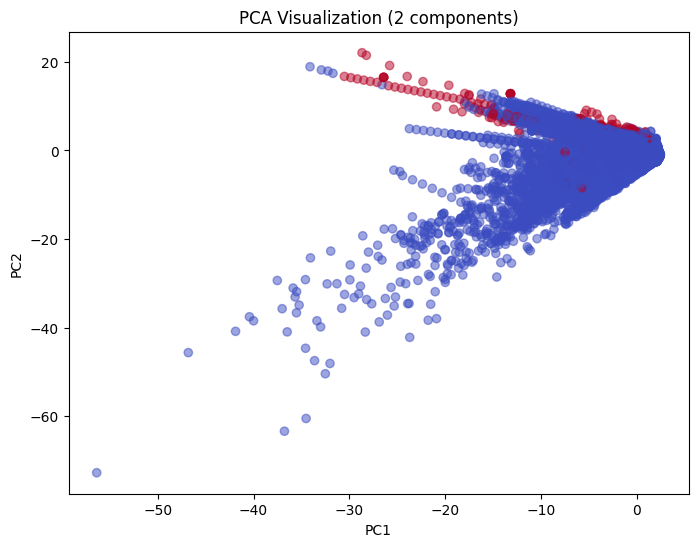

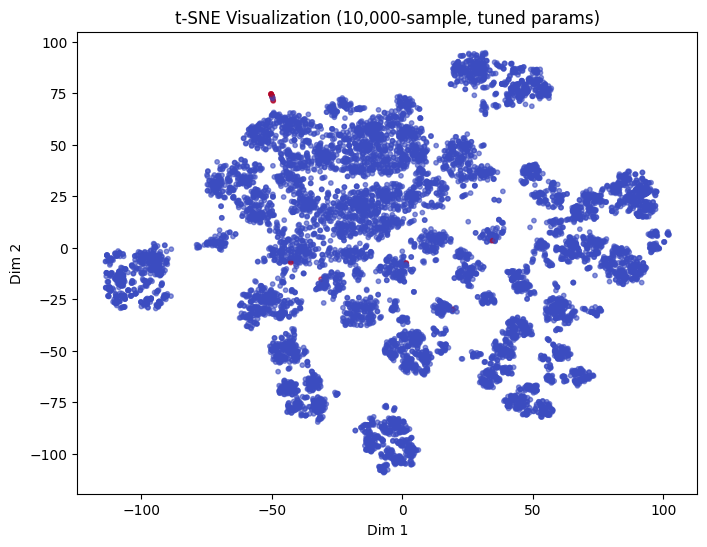

In [3]:
data_scaled = data.copy()
scaler = MinMaxScaler()
data_scaled[['Amount', 'Time']] = scaler.fit_transform(data_scaled[['Amount', 'Time']])

print("=== Scaled Amount & Time ===")
print(data_scaled[['Amount', 'Time']].head())


# PCA for visualization in 2D
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(data_scaled.drop('Class', axis=1))
explained_var = pca.explained_variance_ratio_.sum()
print(f"Explained variance by 2 PCs: {explained_var:.4f}")
plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,0], pca_result[:,1], c=data['Class'], cmap='coolwarm', alpha=0.5)
plt.title("PCA Visualization (2 components)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Sample for speed
sample = data_scaled.sample(10000, random_state=42)
X_sample = sample.drop('Class', axis=1)
y_sample = sample['Class']

# t-SNE with tuned parameters
tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=50,       # try 30, 50
    learning_rate=200,   # helps avoid “snake” artifacts
    max_iter=3000
)
tsne_result = tsne.fit_transform(X_sample)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(tsne_result[:,0], tsne_result[:,1], 
            c=y_sample, cmap='coolwarm', alpha=0.6, s=10)
plt.title("t-SNE Visualization (10,000-sample, tuned params)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()

# <center><div style="font-family: Trebuchet MS; background-color: #f88b31ff; color: #2D2926; padding: 12px; line-height: 0.75;">Unsupervised Techniques</div></center>

In [4]:
X_scaled = scaler.fit_transform(data_scaled.drop('Class', axis=1))
y_true = data_scaled['Class'].values  # kept hidden for now

# === 1. Isolation Forest ===
print("\n=== Isolation Forest ===")
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.001,
    random_state=42
)
y_pred_iso = iso_forest.fit_predict(X_scaled)
# Convert: -1 = anomaly → 1 (fraud), 1 = normal → 0
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)
print("Isolation Forest completed. Predicted anomalies (fraud=1):", np.sum(y_pred_iso))

# === 2. One-Class SVM ===
print("\n=== One-Class SVM ===")
oc_svm = OneClassSVM(kernel="rbf", nu=0.001, gamma="scale")
y_pred_svm = oc_svm.fit_predict(X_scaled)
y_pred_svm = np.where(y_pred_svm == -1, 1, 0)
print("One-Class SVM completed. Predicted anomalies (fraud=1):", np.sum(y_pred_svm))

# === 3. Autoencoder ===
print("\n=== Autoencoder ===")
input_dim = X_scaled.shape[1]

autoencoder = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(16, activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(input_dim, activation="sigmoid")
])

autoencoder.compile(optimizer="adam", loss="mse")

# Train unsupervised: model learns normal transaction structure
autoencoder.fit(X_scaled, X_scaled, epochs=5, batch_size=256, shuffle=True, verbose=1)

# Reconstruction errors as anomaly scores
X_recon = autoencoder.predict(X_scaled, verbose=0)
mse = np.mean(np.square(X_scaled - X_recon), axis=1)

# Choose threshold as top 0.5% highest errors
threshold = np.percentile(mse, 99.5)
y_pred_ae = (mse > threshold).astype(int)

print("Autoencoder completed. Predicted anomalies (fraud=1):", np.sum(y_pred_ae))


=== Isolation Forest ===
Isolation Forest completed. Predicted anomalies (fraud=1): 285

=== One-Class SVM ===
One-Class SVM completed. Predicted anomalies (fraud=1): 285

=== Autoencoder ===
Epoch 1/5
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0044
Epoch 2/5
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0015
Epoch 3/5
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0013
Epoch 4/5
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0012
Epoch 5/5
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0011
Autoencoder completed. Predicted anomalies (fraud=1): 1425


# <center><div style="font-family: Trebuchet MS; background-color: #edf11eff; color: #2D2926; padding: 12px; line-height: 0.75;">Evaluation</div></center>

In [ ]:
# --- Reveal hidden labels (y_true) ---
print("True frauds in dataset:", np.sum(y_true))

# --- Function to evaluate models ---
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n=== {model_name} Evaluation ===")
    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    print("Confusion Matrix:\n", cm)
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")

# --- Evaluate all models ---
evaluate_model(y_true, y_pred_iso, "Isolation Forest")
evaluate_model(y_true, y_pred_svm, "One-Class SVM")
evaluate_model(y_true, y_pred_ae, "Autoencoder")

True frauds in dataset: 492

=== Isolation Forest Evaluation ===
Confusion Matrix:
 [[284113    202]
 [   409     83]]
Precision: 0.2912
Recall:    0.1687
F1-score:  0.2136

=== One-Class SVM Evaluation ===
Confusion Matrix:
 [[284118    197]
 [   404     88]]
Precision: 0.3088
Recall:    0.1789
F1-score:  0.2265

=== Autoencoder Evaluation ===
Confusion Matrix:
 [[283066   1249]
 [   316    176]]
Precision: 0.1235
Recall:    0.3577
F1-score:  0.1836


# <center><div style="font-family: Trebuchet MS; background-color: #fd53b9ff; color: #2D2926; padding: 12px; line-height: 0.75;">Insights</div></center>

=== Isolation Forest Anomalies ===
        Amount      Time
count   285.00    285.00
mean   2140.04  86134.05
std    3357.11  47714.83
min       0.00   1264.00
25%      75.86  41397.00
50%     538.00  93824.00
75%    3502.11 133161.00
max   25691.16 172273.00
=== One-Class SVM Anomalies ===
        Amount      Time
count   285.00    285.00
mean   1112.48  83837.20
std    3109.32  59958.68
min       0.00     46.00
25%       1.52  26752.00
50%      30.31  86570.00
75%     303.80 145283.00
max   25691.16 172778.00
=== Autoencoder Anomalies ===
        Amount      Time
count  1425.00   1425.00
mean    602.04  95070.69
std    1786.29  47888.66
min       0.00    547.00
25%       2.00  53133.00
50%      34.90  95299.00
75%     209.65 138773.00
max   25691.16 172786.00

=== Isolation Forest Anomalies on PCA ===


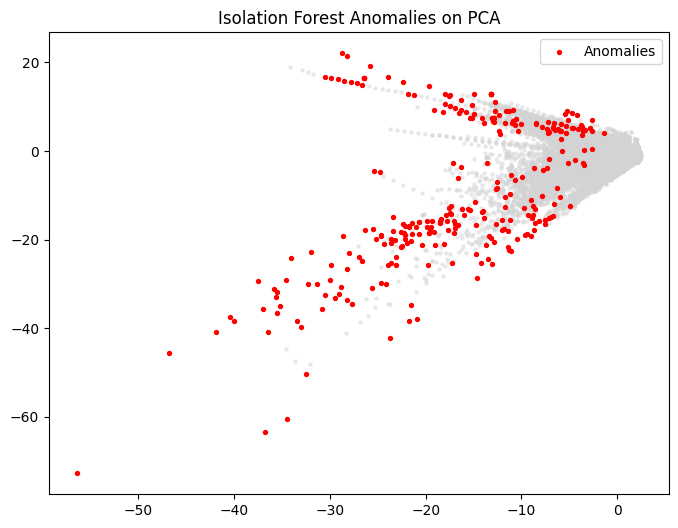


=== One-Class SVM Anomalies on PCA ===


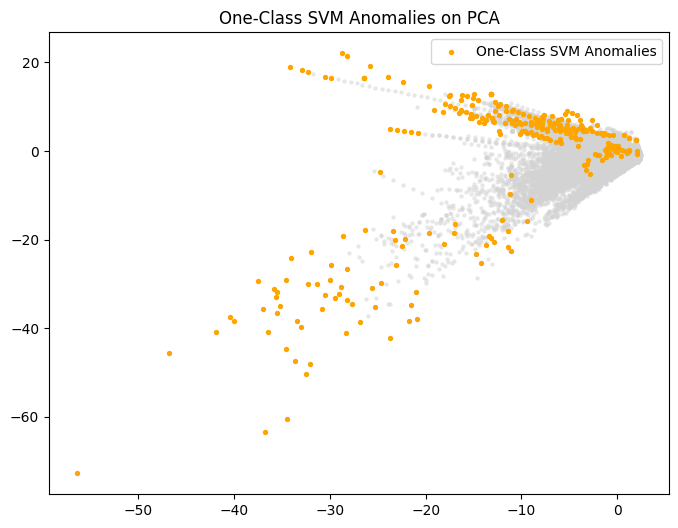


=== Autoencoder Anomalies on PCA ===


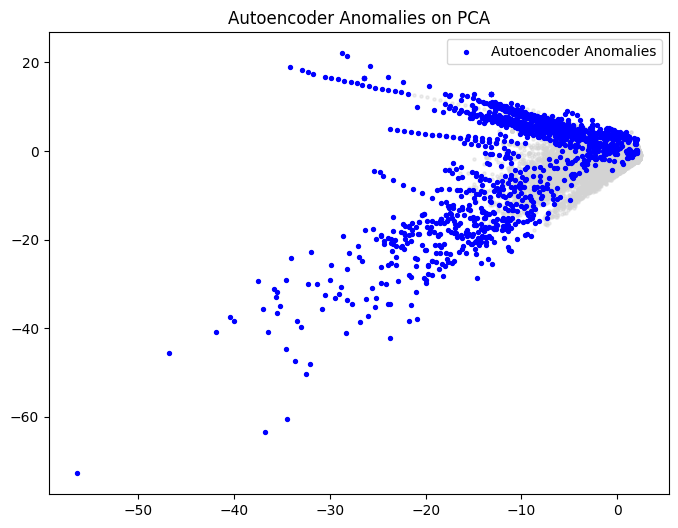


=== t-SNE Visualization of True Fraud Distribution ===


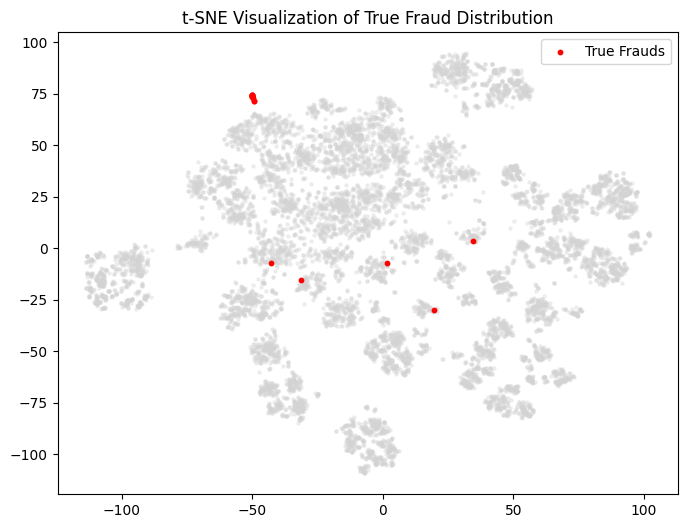


=== t-SNE Visualization - Autoencoder Detected Anomalies ===


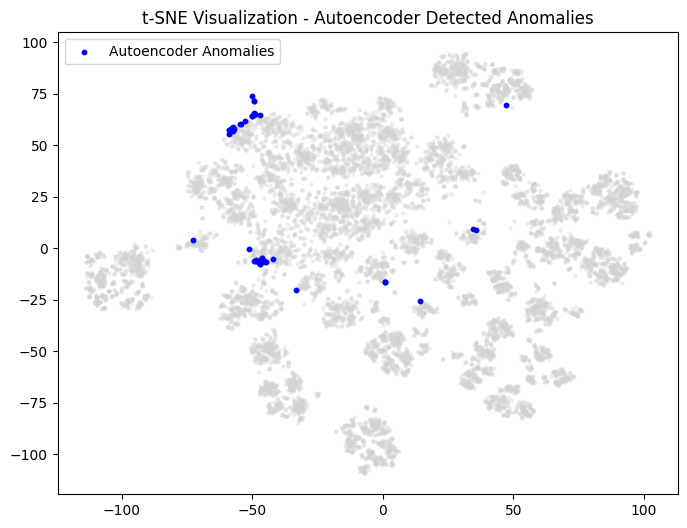

In [8]:
# Identify anomalies from each model
anomalies_iso = data[y_pred_iso == 1]
anomalies_svm = data[y_pred_svm == 1]
anomalies_ae = data[y_pred_ae == 1]

# Inspect statistical patterns
print("=== Isolation Forest Anomalies ===")
print(anomalies_iso[['Amount', 'Time']].describe())

print("=== One-Class SVM Anomalies ===")
print(anomalies_svm[['Amount', 'Time']].describe())

print("=== Autoencoder Anomalies ===")
print(anomalies_ae[['Amount', 'Time']].describe())


# Visualize anomalies on PCA
print("\n=== Isolation Forest Anomalies on PCA ===")
plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,0], pca_result[:,1], c='lightgray', s=5, alpha=0.4)
plt.scatter(pca_result[y_pred_iso==1,0], pca_result[y_pred_iso==1,1],
            c='red', s=8, label='Anomalies')
plt.legend(); plt.title("Isolation Forest Anomalies on PCA")
plt.show()


print("\n=== One-Class SVM Anomalies on PCA ===")
plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,0], pca_result[:,1], c='lightgray', s=5, alpha=0.4)
plt.scatter(pca_result[y_pred_svm==1,0], pca_result[y_pred_svm==1,1],
            c='orange', s=8, label='One-Class SVM Anomalies')
plt.legend(); plt.title("One-Class SVM Anomalies on PCA")
plt.show()


print("\n=== Autoencoder Anomalies on PCA ===")
plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,0], pca_result[:,1], c='lightgray', s=5, alpha=0.4)
plt.scatter(pca_result[y_pred_ae==1,0], pca_result[y_pred_ae==1,1],
            c='blue', s=8, label='Autoencoder Anomalies')
plt.legend(); plt.title("Autoencoder Anomalies on PCA")
plt.show()



# === t-SNE visualization to explore anomaly distribution ===
print("\n=== t-SNE Visualization of True Fraud Distribution ===")
plt.figure(figsize=(8,6))
plt.scatter(tsne_result[:,0], tsne_result[:,1], c='lightgray', s=5, alpha=0.3)
plt.scatter(tsne_result[y_sample==1,0], tsne_result[y_sample==1,1],
            c='red', s=10, label='True Frauds')
plt.title("t-SNE Visualization of True Fraud Distribution")
plt.legend()
plt.show()




# Overlay anomalies detected by Autoencoder on t-SNE 
print("\n=== t-SNE Visualization - Autoencoder Detected Anomalies ===")
y_pred_ae_sample = y_pred_ae[sample.index]   # Recreate a subset of predictions matching the sample indices
plt.figure(figsize=(8,6))
plt.scatter(tsne_result[:,0], tsne_result[:,1], c='lightgray', s=5, alpha=0.3)
plt.scatter(tsne_result[y_pred_ae_sample==1,0],
            tsne_result[y_pred_ae_sample==1,1],
            c='blue', s=10, label='Autoencoder Anomalies')
plt.title("t-SNE Visualization - Autoencoder Detected Anomalies")
plt.legend()
plt.show()

*Insights Interpretation*:


1. Which types of transactions were flagged?
   
   ~ Most flagged transactions have higher transaction amounts compared to normal ones.

   ~ Many flagged points occur at specific time intervals, suggesting that certain transaction periods might be riskier.

   ~ The Autoencoder flagged more subtle anomalies (not only large amounts), showing sensitivity to unusual feature combinations (V1–V28).


2. What patterns exist in detected anomalies?
   
   ~ On PCA/t-SNE plots, anomalies tend to cluster away from dense normal regions — indicating that the model identifies data points that behave differently from the majority  -feature-space outliers-.

   ~ Some fraudulent transactions form small isolated groups, suggesting that certain frauds share similar hidden characteristics or patterns. 


Overall, models detect points that deviate from the dominant feature correlations, implying non-linear or rare combinations typical of fraud.